# Exploratory Data Analysis (EDA) of Instacart data

## <u>Executive Summary</u>

<b>Data:</b>
- There are a total of 206,209 users in the dataset.
- Their past orders are given in evaluation set: 'prior' which amounts to 3,214,874 orders.
- Out of the total 206k users, the next order details for 131,209 of them are given in evaluation set: 'train' while the next order details for the remaining 75,000 denoted by evaluation set: 'test' need to be predicted.

<b>Understanding Prior orders</b>:
- Count of orders per user ranges from 3 to 99, however the distribution is right skewed.
- In spite of this huge range, 50% of the users have placed only 9 orders in the past (median value).
- Only one quarter of the users have placed >= 20 orders.  
<br>
- 10 AM to 4 PM is the busiest time in a day garnering high volume of orders in this time period.
- In a week, maximum number of orders are placed on Saturday and Sunday.
- Peak number of orders are placed at Saturday 2 PM and Sunday 10 AM.
<br>
- Maximum number of orders are placed at an interval (shop gap) of one week (7 days) or one month (30 days) from the previous order. Compared to the total number of orders placed, Weekly and Monthly orders amount to 11% each.
- Approx two-thirds (64%) of all the orders are placed at a shop gap of 10 days or less.
- Though 64% of all the orders have been placed at a shopgap of 10 days or less from the prior order, average shop gap at user level is more dispersed. Around half of our customer base has an average shop gap of 14.7 days.
- High proportion of the users are weekly and monthly shoppers (~ 5% of the customer base respectively). In addition, a large portion of users are in the average shop gap range of 8 to 15 (~40% of the entire customer base). 
- <b><i>The time range between 7 to 15 days would  an ideal time to send shopping reminders to users to activate shopping behavior </i></b>.
<br>

- Basket size ranges from 1 to 145 in terms of the number of unique products. 50% of all the orders have more than 8 products in them.
- Half of our customer base have an average basket size of 9 products or more.
- Orders placed with a shop gap of more than 4 days have an average basket size of above 10 products.
<br>

- Approximately 9% of all the products in the inventory have never been reordered by the same customer.
- On an average, 63% of every basket consists of products that have been reorderd by the customer (excluding the baskets corresponding to first shop of a customer with Instacart).
- <b><i>94% of all orders (excluding first shops of customers) have at least one reordered product in them.</i></b>
- Excluding the first shops of customers, about a quarter (23.1%) of the orders have all products being reordered by the corresponding customer.


## <u>Part I. Loading the datasets</u>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from IPython.display import display

pd.options.mode.chained_assignment = None

%matplotlib inline
cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# define the fig size of all figures
plt.rcParams["figure.figsize"] = (10,10)

In [ ]:
import os
wd = os.getcwd()
os.chdir('..')
new_wd = os.getcwd()

data_directory_path = new_wd + '\Data'

In [ ]:
# Converting the days and hours from numbers to their interpretable form
days_of_week = {0: 'Saturday', 
                1: 'Sunday', 
                2: 'Monday',
                3: 'Tuesday',
                4: 'Wednesday',
                5: 'Thursday',
                6: 'Friday'}
hour_nums = list(range(24))
hours_of_day = {hour_num:datetime.time(hour_num).strftime("%I:00 %p") for hour_num in hour_nums}

In [ ]:
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object, 'category']:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

# Annotate text on graph
def annotate_text(p, append_to_text='%'):
    for p in ax.patches:
        txt = str(p.get_height().round(2)) + append_to_text
        txt_x = p.get_x() + p.get_width()/2.
        txt_y = 0.92*p.get_height()
        ax.text(txt_x,txt_y,txt, fontsize=20, color='#004235', ha='center', va='bottom')

In [ ]:
aisles = pd.read_csv(data_directory_path + r'\aisles.csv')
aisles = reduce_mem_usage(aisles)

departments = pd.read_csv(data_directory_path + r'\departments.csv')
departments = reduce_mem_usage(departments)

order_products_prior = pd.read_csv(data_directory_path + r'\order_products__prior.csv')
order_products_prior = reduce_mem_usage(order_products_prior)

order_products_train = pd.read_csv(data_directory_path + r'\order_products__train.csv')
order_products_train = reduce_mem_usage(order_products_train)

orders = pd.read_csv(data_directory_path + r'\orders.csv')

# Replacing numbers with their corresponding hour representation
orders['order_hour_of_day'] = orders['order_hour_of_day'].replace(hours_of_day)
orders['order_hour_of_day'] = pd.Categorical(orders['order_hour_of_day'], ordered=True, categories=list(hours_of_day.values()))
# Replacing numbers with their corresponding day of week
# Define the categories of days of week sorted normally from Saturday to Friday
orders['order_dow'] = orders['order_dow'].replace(days_of_week)
orders['order_dow'] = pd.Categorical(orders['order_dow'], ordered=True, categories=list(days_of_week.values()))
orders = reduce_mem_usage(orders)

products = pd.read_csv(data_directory_path + r'\products.csv')
products = reduce_mem_usage(products)

## <u>Part II. Understanding the data</u>

In [ ]:
df_list = %who_ls DataFrame
for df in df_list:
    print("================\n")
    print('Shape of ', df,' dataset: ', eval(df).shape)
    print(eval(df).info(), '\n')

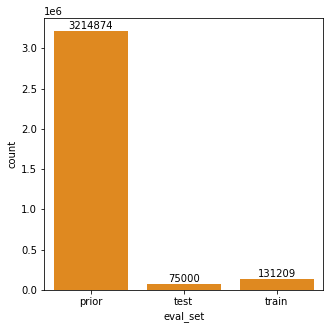

In [7]:
# Count of orders in prior, train and test evaluation set
plt.figure(figsize = (5,5))
p = sns.countplot(data = orders, x = 'eval_set', color = 'darkorange')
for i in p.containers:
    p.bar_label(i, fmt = '%d')


In [8]:
# Count of unique orders 
counts_orders = orders.groupby(['eval_set'], as_index=False).agg({"order_id":pd.Series.nunique})
print("Count of unqiue orders in each set: \n", counts_orders)
del counts_orders

Count of unqiue orders in each set: 
   eval_set  order_id
0    prior   3214874
1     test     75000
2    train    131209


In [9]:
# Count of unique users
print("Count of total unique users: ",orders['user_id'].nunique())

count_users = orders.groupby(['eval_set'], as_index=False).agg({"user_id":pd.Series.nunique}).rename(columns={'user_id':'count_users'})
print(count_users)
del count_users

Count of total unique users:  206209
  eval_set  count_users
0    prior       206209
1     test        75000
2    train       131209


#### <u>Findings</u>:
- There are a total of 206,209 users in the dataset.
- Their past orders are given in evaluation set: 'prior' which amounts to 3,214,874 orders.
- Out of the total 206k users, the next order details for 131,209 of them are given in evaluation set: 'train' while the next order details for the remaining 75,000 denoted by evaluation set: 'test' need to be predicted. 

## <u>Part III. Data Preparation</u>

In [10]:
# Combining prior and train order sets
# Joining with orders, products, departments and aisles to collate all information 

order_details_prior = order_products_prior.merge(orders, on='order_id', how='left').merge(products, on='product_id', how='left').merge(departments, on='department_id').merge(aisles, on='aisle_id')

In [11]:
print(order_details_prior.shape)
order_details_prior.head()

(32434489, 15)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,Thursday,09:00 AM,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,22,23341,6,1,30822,prior,25,Sunday,08:00 AM,12.0,Large Grade AA Eggs,86,16,dairy eggs,eggs
2,25,6383,7,1,59897,prior,19,Friday,10:00 AM,25.0,All Whites 100% Egg Whites,86,16,dairy eggs,eggs
3,26,33120,5,0,153404,prior,2,Saturday,04:00 PM,7.0,Organic Egg Whites,86,16,dairy eggs,eggs
4,55,11520,12,0,127522,prior,8,Wednesday,02:00 PM,5.0,Large Alfresco Eggs,86,16,dairy eggs,eggs


In [12]:
# Columns in the combined dataset
order_details_prior.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered', 'user_id',
       'eval_set', 'order_number', 'order_dow', 'order_hour_of_day',
       'days_since_prior_order', 'product_name', 'aisle_id', 'department_id',
       'department', 'aisle'],
      dtype='object')

## <u>Part IV. Exploratory Data Analysis (EDA)</u>

### <u>Understanding Orders per User</u>

In [13]:
df_orders_user_counts = order_details_prior.groupby(['user_id'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})
df_orders_user_counts['order_counts'].describe()

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_counts, dtype: float64

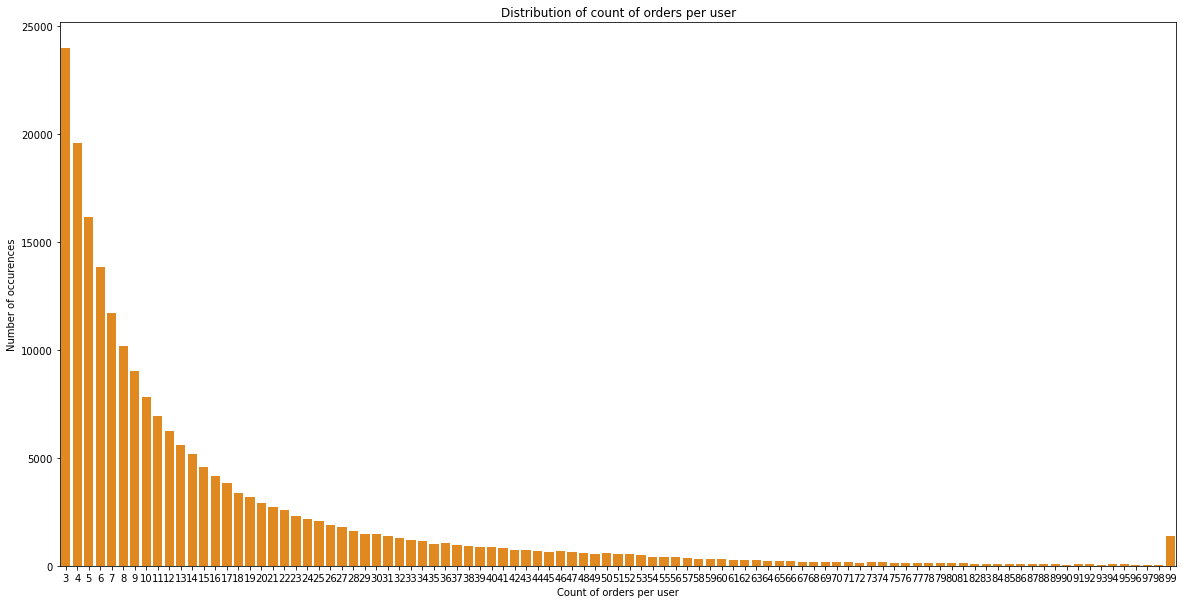

In [14]:
plt.figure(figsize=(20,10))
sns.countplot(x = 'order_counts', data = df_orders_user_counts, color = 'darkorange')
plt.xlabel('Count of orders per user')
plt.ylabel('Number of occurences')
plt.title('Distribution of count of orders per user')
plt.show()

del df_orders_user_counts

#### <u>Findings</u>:
- Count of orders per user ranges from 3 to 99, however the distribution is right skewed.
- In spite of this huge range, 50% of the users have placed only 9 orders (median value).
- Only one quarter of the users have placed >= 20 orders.

### <u>Understanding Order placement by Day of Week and Time of Day</u>

In [15]:
df_orders_dow_counts = order_details_prior.groupby(['order_dow'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})

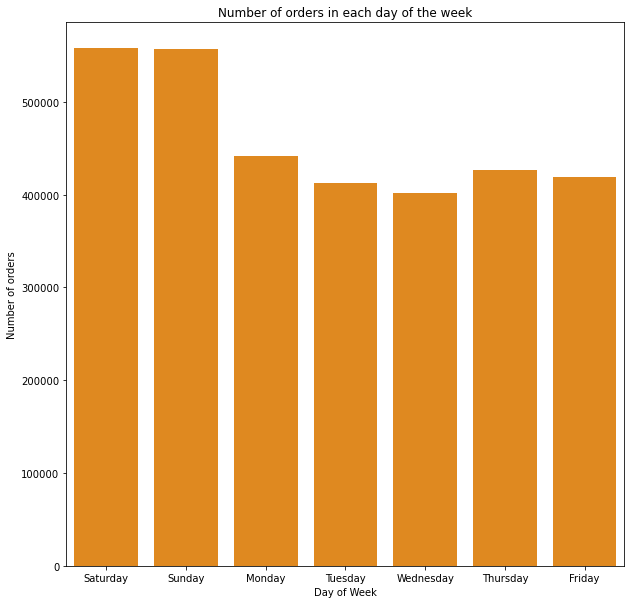

In [16]:
sns.barplot(x = 'order_dow', y = 'order_counts', data = df_orders_dow_counts, color = 'darkorange')
plt.xlabel('Day of Week')
plt.ylabel('Number of orders')
plt.title('Number of orders in each day of the week')
plt.show()

del df_orders_dow_counts

In [17]:
df_orders_hod_counts = order_details_prior.groupby(['order_hour_of_day'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})

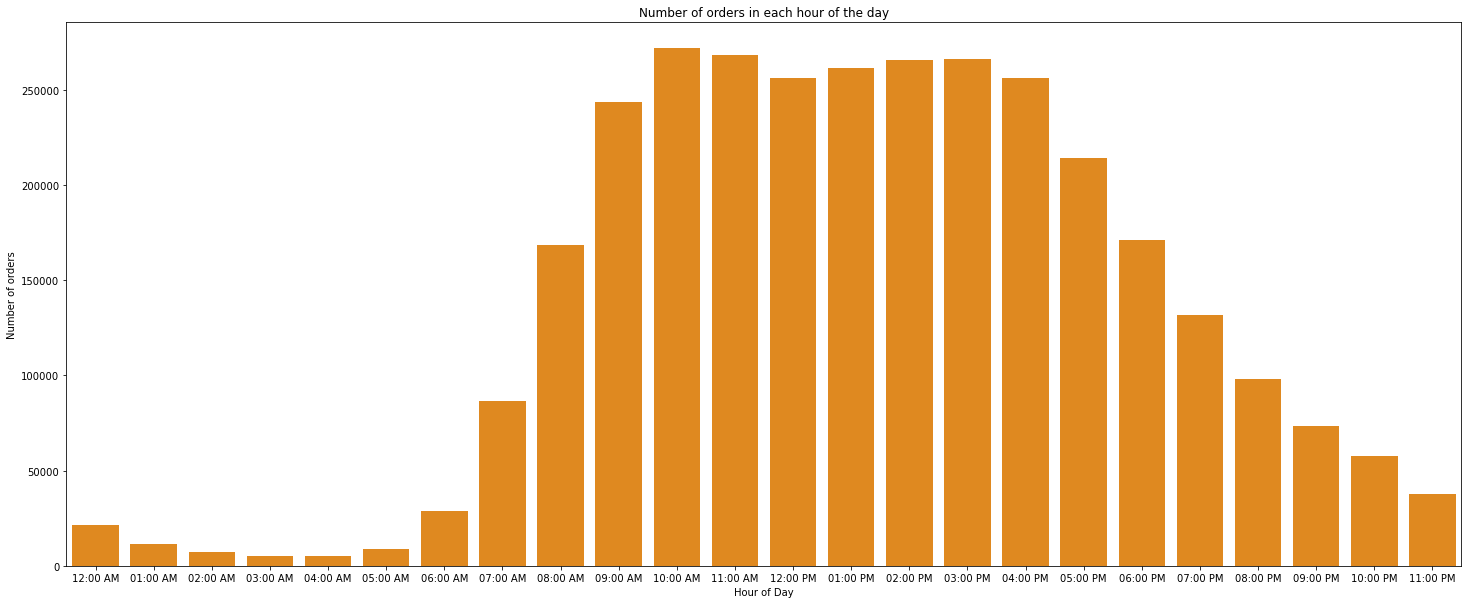

In [18]:
plt.figure(figsize=(25,10))
sns.barplot(x = 'order_hour_of_day', y = 'order_counts', data = df_orders_hod_counts, color = 'darkorange')
plt.xlabel('Hour of Day')
plt.ylabel('Number of orders')
plt.title('Number of orders in each hour of the day')
plt.show()

del df_orders_hod_counts

In [19]:
df_orders_dow_hod_counts = order_details_prior.groupby(['order_dow','order_hour_of_day'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})
heatmap_data = df_orders_dow_hod_counts.pivot( 'order_hour_of_day','order_dow', 'order_counts')

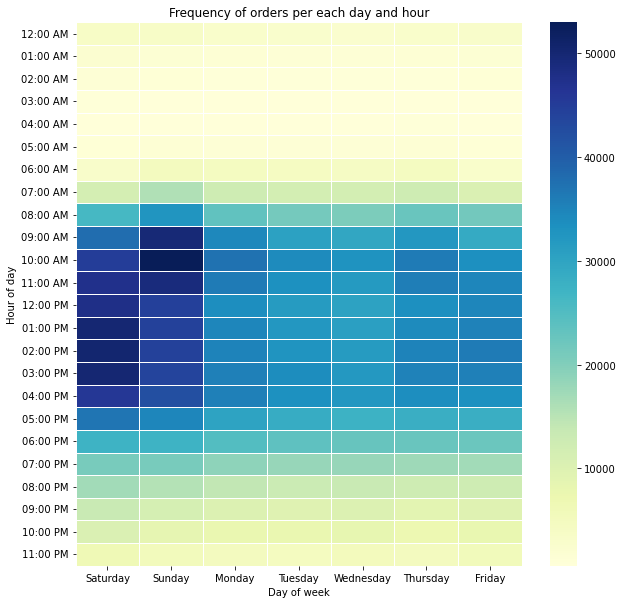

In [20]:
ax = sns.heatmap(data=heatmap_data, cmap="YlGnBu", linewidths=.5)
plt.title('Frequency of orders per each day and hour')
plt.ylabel('Hour of day')
plt.xlabel('Day of week')
plt.show()

del df_orders_dow_hod_counts
del heatmap_data

#### <u>Findings</u>:
 - 10 AM to 4 PM are the busiest hours in a day garnering high volume of orders in this time period.
 - In a general week, maximum number of orders are placed on Saturday and Sunday.
 - Peak number of orders are placed at Saturday 2 PM and Sunday 10 AM.

### <u>Understanding shop gap between orders</u>

In [21]:
# Remove first orders of each customer since the corresponding shop gap is Null
# Keeping only the data corresponding to order_number > 1 for shopgap related metrics

order_details_prior_exc_1 = order_details_prior[order_details_prior['order_number'] > 1]
len(pd.unique(order_details_prior_exc_1['order_id']))

3008665

In [22]:
df_orders_shopgap_counts = order_details_prior_exc_1.groupby(['days_since_prior_order'], as_index=False).agg({"order_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts'})

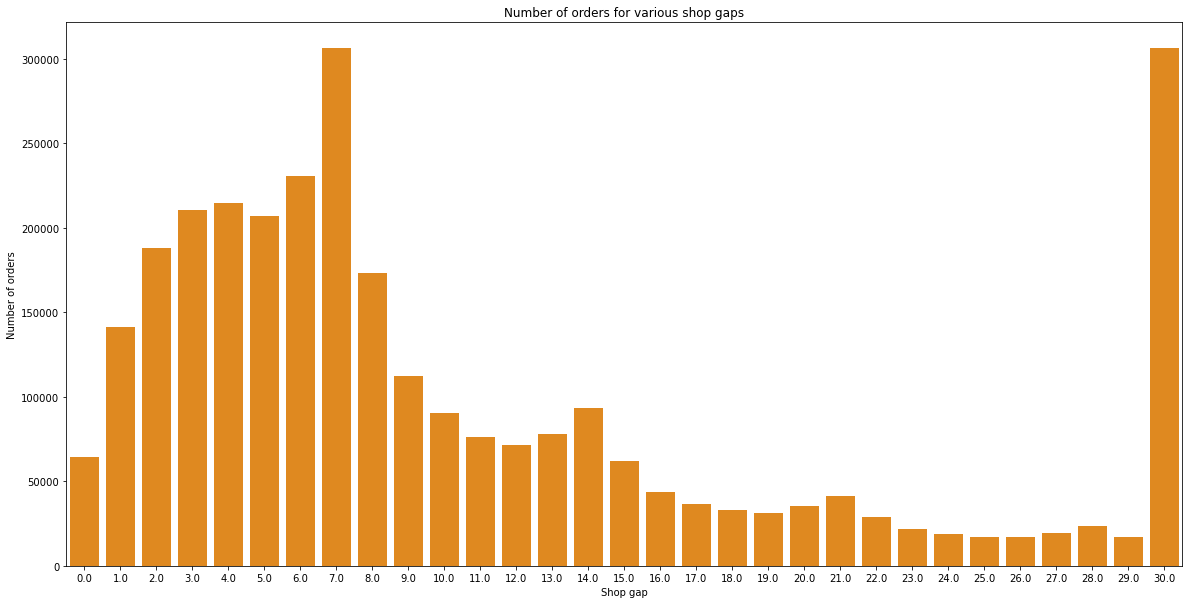

In [23]:
plt.figure(figsize=(20,10))
sns.barplot(x = 'days_since_prior_order', y = 'order_counts', data = df_orders_shopgap_counts, color = 'darkorange')
plt.xlabel('Shop gap')
plt.ylabel('Number of orders')
plt.title('Number of orders for various shop gaps')
plt.show()

del df_orders_shopgap_counts

#### <u>Findings</u>:
- Maximum number of orders are placed at an interval of one week (7 days) or one month (30 days) from the previous order. Compared to the total number of orders placed, Weekly and Monthly orders amount to 11% each.
- Approx two-thirds (64%) of all the orders are placed at a shop gap of 10 days or less.

### Understanding shop gap per user

In [24]:
df_user_avg_shopgap = order_details_prior_exc_1.groupby(['user_id'], as_index=False)['days_since_prior_order'].agg(['mean','median']).rename(columns={'mean':'avg_shop_gap', 'median':'median_shop_gap'})

In [25]:
df_user_avg_shopgap['avg_shop_gap'] = df_user_avg_shopgap['avg_shop_gap'].astype(float)
df_user_avg_shopgap['median_shop_gap'] = df_user_avg_shopgap['median_shop_gap'].astype(float)
df_user_avg_shopgap['avg_shop_gap'].describe()

count    206209.000000
mean         15.469680
std           7.207451
min           0.000000
25%           9.554688
50%          14.695312
75%          20.718750
max          30.000000
Name: avg_shop_gap, dtype: float64

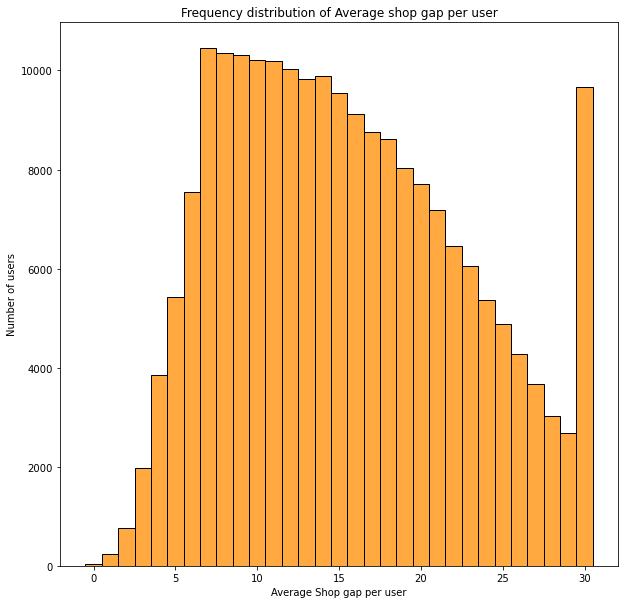

In [26]:
sns.histplot(data=df_user_avg_shopgap, x="avg_shop_gap", discrete = True, color = 'darkorange')
plt.xlabel('Average Shop gap per user')
plt.ylabel('Number of users')
plt.title('Frequency distribution of Average shop gap per user')
plt.show()

del order_details_prior_exc_1
del df_user_avg_shopgap

#### <u>Findings</u>:
Though 64% of all the orders have been placed at a shopgap of 10 days or less from the prior order, average shop gap at user level is more dispersed. Around half of our customer base has an average shop gap of 14.7 days.

High proportion of the users are weekly and monthly shoppers (~ 5% of the customer base respectively). In addition, a large portion of users are in the average shop gap range of 8 to 15 (~40% of the entire customer base). <b><i>The time range between 7 - 15 days would  an ideal time to send shopping reminders to users to activate shopping behavior </b></i>.

### <u>Understanding basket composition</u>

In [27]:
print("Number of unique products that have been ordered:", order_details_prior['product_name'].nunique())

df_product_counts = order_details_prior.groupby(['product_name'], as_index=False).agg({"order_id":pd.Series.nunique, "user_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts', 'user_id': 'user_counts'})

Number of unique products that have been ordered: 49677


In [28]:
print("Top 10 products based on number of orders:")
df_product_counts.nlargest(10, 'order_counts')[['product_name', 'order_counts']].reset_index(drop = True)

Top 10 products based on number of orders:


,product_name,order_counts
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


In [29]:
print("Top 10 products based on number of users ordering them:")
df_product_counts.nlargest(10, 'user_counts')[['product_name', 'user_counts']].reset_index(drop = True)

Top 10 products based on number of users ordering them:


,product_name,user_counts
0,Banana,73956
1,Bag of Organic Bananas,63537
2,Organic Strawberries,58838
3,Organic Baby Spinach,55037
4,Large Lemon,46402
5,Limes,44859
6,Organic Hass Avocado,43453
7,Strawberries,43149
8,Organic Avocado,42771
9,Organic Blueberries,37138


In [30]:
del df_product_counts

In [31]:
df_product_dept_counts = order_details_prior.groupby(['department'], as_index=False).agg({"order_id":pd.Series.nunique, "user_id":pd.Series.nunique}).rename(columns={'order_id':'order_counts', 'user_id': 'user_counts'})

In [32]:
df_product_dept_counts.nlargest(10, 'order_counts')[['department', 'order_counts']].reset_index(drop = True)

,department,order_counts
0,produce,2409320
1,dairy eggs,2177338
2,beverages,1457351
3,snacks,1391447
4,frozen,1181018
5,pantry,1117892
6,bakery,881556
7,deli,770300
8,canned goods,681305
9,dry goods pasta,597862


In [33]:
df_product_dept_counts.nlargest(10, 'user_counts')[['department', 'user_counts']].reset_index(drop = True)

,department,user_counts
0,produce,193237
1,dairy eggs,190565
2,snacks,174219
3,beverages,172795
4,pantry,172755
5,frozen,163233
6,bakery,140612
7,deli,133865
8,canned goods,133733
9,dry goods pasta,124820


In [34]:
del df_product_dept_counts

In [35]:
df_order_product_counts = order_details_prior.groupby(['order_id'], as_index=False).agg({"product_id":pd.Series.nunique}).rename(columns={'product_id':'product_counts'})
df_order_product_counts = df_order_product_counts.merge(orders, on='order_id', how='left') 

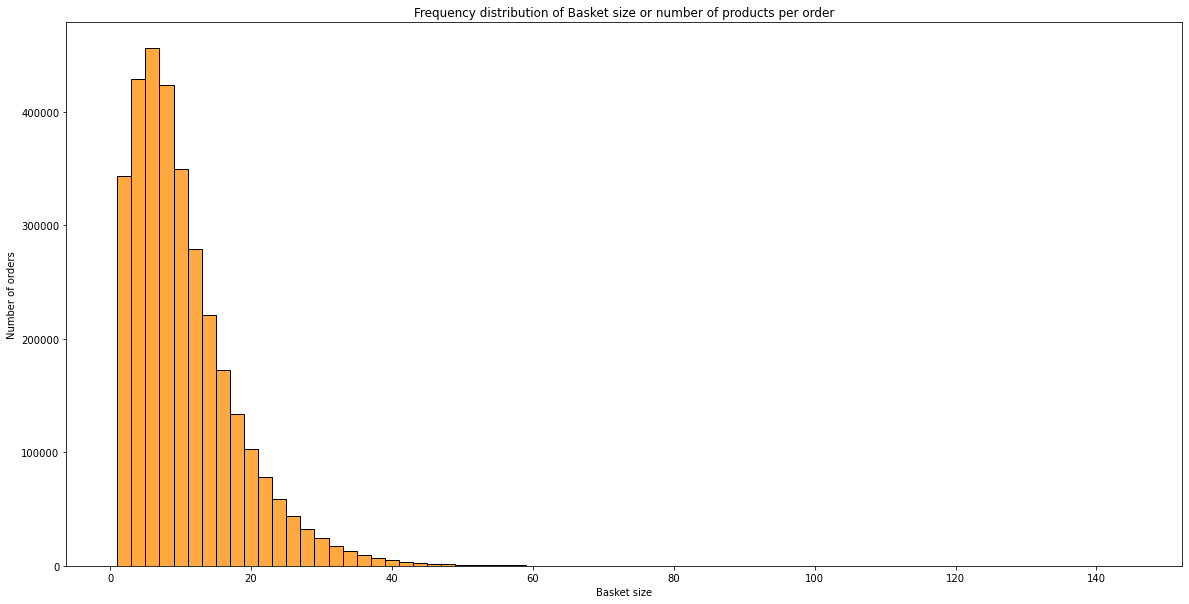

In [36]:
plt.figure(figsize = (20,10))
sns.histplot(data = df_order_product_counts, x="product_counts", color = 'darkorange', binwidth = 2)
plt.xlabel('Basket size')
plt.ylabel('Number of orders')
plt.title('Frequency distribution of Basket size or number of products per order')
plt.show()

In [37]:
df_order_product_counts['product_counts'].describe()

count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_counts, dtype: float64

In [38]:
df_user_products_counts = df_order_product_counts.groupby(['user_id'], as_index=False).agg({"product_counts":'mean'}).rename(columns={'product_counts':'avg_product_per_ord'})
df_user_products_counts['avg_product_per_ord'].describe()

count    206209.000000
mean          9.951586
std           5.863570
min           1.000000
25%           5.740741
50%           8.933333
75%          13.000000
max          70.250000
Name: avg_product_per_ord, dtype: float64

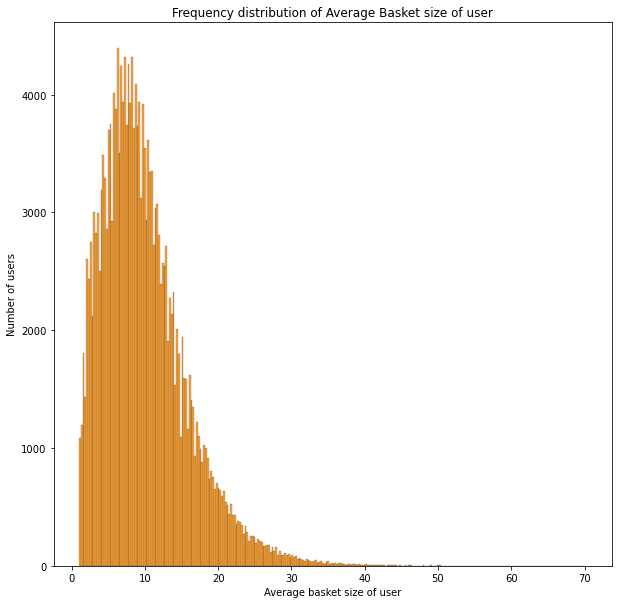

In [39]:
sns.histplot(data = df_user_products_counts, x = 'avg_product_per_ord', color = 'darkorange')
plt.xlabel('Average basket size of user')
plt.ylabel('Number of users')
plt.title('Frequency distribution of Average Basket size of user')
plt.show()

del df_user_products_counts

In [40]:
df_shopgap_products_counts = df_order_product_counts.groupby(['days_since_prior_order'], as_index=False).agg({"product_counts":'mean'}).rename(columns={'product_counts':'avg_product_per_ord'})

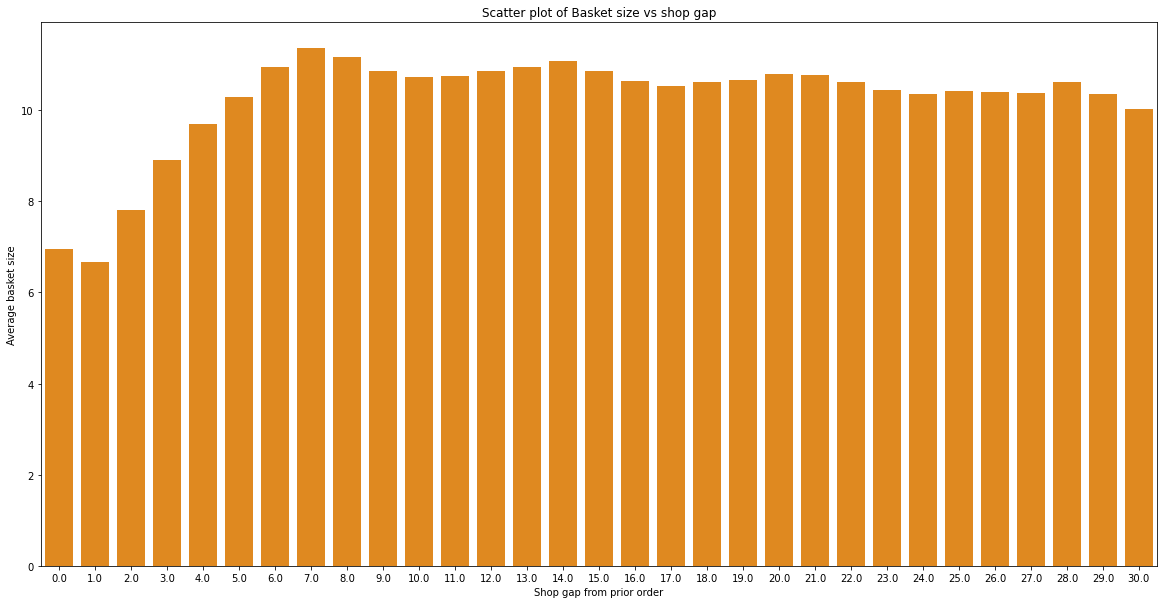

In [41]:
plt.figure(figsize = (20,10))
sns.barplot(data = df_shopgap_products_counts, x = 'days_since_prior_order', y = 'avg_product_per_ord', color = 'darkorange')
plt.xlabel('Shop gap from prior order')
plt.ylabel('Average basket size')
plt.title('Scatter plot of Basket size vs shop gap')
plt.show()

del df_shopgap_products_counts

In [42]:
del df_order_product_counts

#### <u>Findings</u>:
- Basket size ranges from 1 to 145 in terms of the number of unique products. 50% of all the orders have more than 8 products in them.
- Half of our customer base have an average basket size of 9 products or more.
- Orders placed with a shop gap of more than 4 days have an average basket size of above 10 products.  

### <u>Understanding reordering behavior</u>

In [43]:
# Calculate number of orders and reorders for each product
prod_order_counts = order_details_prior.groupby('product_id').size().reset_index(name = 'all_occurences')
prod_reorder_counts = order_details_prior.groupby('product_id')['reordered'].apply(lambda x: (x == 1).sum()).reset_index(name = 'reordered_occurences')

prod_counts = prod_order_counts.merge(prod_reorder_counts, on = 'product_id', how = 'left')

In [44]:
pct_prod_0_reord = round(len(prod_counts[prod_counts['reordered_occurences']==0])*100/len(prod_counts),2)
print(pct_prod_0_reord,"% of all the products in the inventory have never been reordered by the same customer.")

8.8 % of all the products in the inventory have never been reordered by the same customer.


In [45]:
# Calculate count of all products and reordered products in each order

order_prod_counts = order_details_prior.groupby(['order_id', 'user_id', 'order_number']).size().reset_index(name = 'prod_count')

# order_reorder_counts = order_details_prior[order_details_prior['reordered'] == 1].groupby(['order_id']).size().reset_index(name='reordered_count') 
# (2826361, 2)
order_reorder_counts = order_details_prior.groupby('order_id')['reordered'].apply(lambda x: (x == 1).sum()).reset_index(name = 'reordered_count')
# (3214874, 2)

In [46]:
order_prod_reorder_counts = order_prod_counts.merge(order_reorder_counts, on = 'order_id', how = 'left' )

In [47]:
#Excluding first shop orders of all customers since they will have no reordered products
order_prod_reorder_counts_exc_1 = order_prod_reorder_counts[order_prod_reorder_counts['order_number']>1]

In [48]:
ord_count_exc_1  = len(order_prod_reorder_counts_exc_1)
print("Total number of orders excluding the first shop of customers is",ord_count_exc_1,".")

Total number of orders excluding the first shop of customers is 3008665 .


In [49]:
order_prod_reorder_counts_exc_1['reorder_pct'] = order_prod_reorder_counts_exc_1['reordered_count']*100/ order_prod_reorder_counts_exc_1['prod_count']
order_prod_reorder_counts_exc_1['reorder_pct'].describe()

count    3.008665e+06
mean     6.396947e+01
std      3.095133e+01
min      0.000000e+00
25%      4.166667e+01
50%      6.666667e+01
75%      9.285714e+01
max      1.000000e+02
Name: reorder_pct, dtype: float64

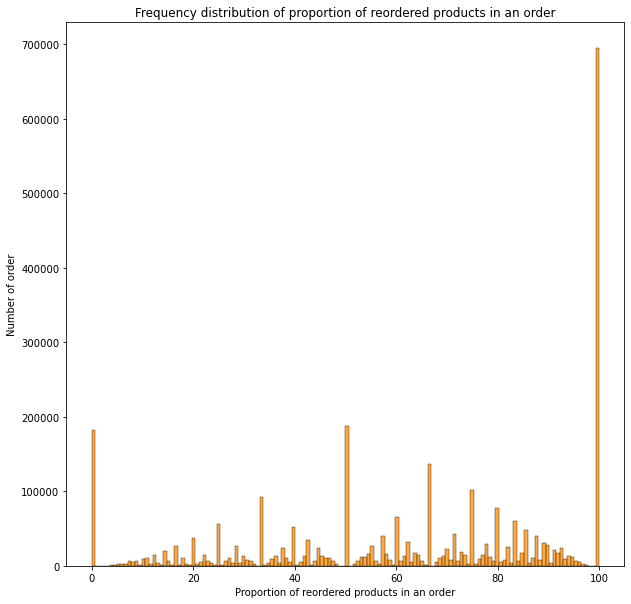

In [50]:
sns.histplot(order_prod_reorder_counts_exc_1, x = 'reorder_pct', color = 'darkorange')
plt.xlabel('Proportion of reordered products in an order')
plt.ylabel('Number of order')
plt.title('Frequency distribution of proportion of reordered products in an order')
plt.show()

In [51]:
pct_0pct_reord = round(len(order_prod_reorder_counts_exc_1[order_prod_reorder_counts_exc_1['reorder_pct'] == 0])*100/ord_count_exc_1,2)
print("Proportion of orders having no products in the basket as reordered products is",pct_0pct_reord,"%.")
print("Proportion of orders having at least 1 product in the basket as reordered is",100-pct_0pct_reord,"%.")

Proportion of orders having no products in the basket as reordered products is 6.06 %.
Proportion of orders having at least 1 product in the basket as reordered is 93.94 %.


In [52]:
pct_100pct_reord = round(len(order_prod_reorder_counts_exc_1[order_prod_reorder_counts_exc_1['reorder_pct'] == 100])*100/ord_count_exc_1,2)
print("Proportion of orders having all products in the basket as reordered products is",pct_100pct_reord,"%.")

Proportion of orders having all products in the basket as reordered products is 23.1 %.


#### <u>Findings</u>:
* Approximately 9% of all the products in the inventory have never been reordered by the same customer.
* On an average, 63% of every basket consists of products that have been reorderd by the customer (excluding the baskets corresponding to first shop of a customer with Instacart).
* 94% of all orders (excluding first shops of customers) have at least one reordered product in them.
* Excluding the first shops of customers, about a quarter (23.1%) of the orders have all products being reordered by the corresponding customer.